## Bragg reflection  
---



### code to simulation on the Bragg reflection  
- Represent the Bragg reflection in 2D dimension.


-----------
Initializing structure...
time for choose_chunkdivision = 0.000374079 s
Working in 2D dimensions.
Computational cell is 5 x 12.5333 x 0 with resolution 60
time for set_epsilon = 0.173987 s
-----------
Meep progress: 44.15/200.0 = 22.1% done in 4.0s, 14.1s to go
on time step 5298 (time=44.15), 0.000755123 s/step
Meep progress: 87.79166666666667/200.0 = 43.9% done in 8.0s, 10.2s to go
on time step 10536 (time=87.8), 0.000763762 s/step
Meep progress: 132.10833333333332/200.0 = 66.1% done in 12.0s, 6.2s to go
on time step 15855 (time=132.125), 0.000752112 s/step
Meep progress: 178.74166666666667/200.0 = 89.4% done in 16.0s, 1.9s to go
on time step 21452 (time=178.767), 0.000714732 s/step
run 0 finished at t = 200.0 (24000 timesteps)
on time step 26623 (time=221.858), 0.000773723 s/step
Meep progress: 42.69166666666666/400.0 = 10.7% done in 4.0s, 33.5s to go
on time step 31899 (time=265.825), 0.000758159 s/step
Meep progress: 87.80833333333334/400.0 = 22.0% done in 8.0s, 28.4s t

run 1 finished at t = 400.0 (48000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000496864 s
Working in 2D dimensions.
Computational cell is 5 x 12.5333 x 0 with resolution 60
     block, center = (0,-5.145,0)
          size (1e+20,0.25,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-4.9315,0)
          size (1e+20,0.177,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.9881,1.9881,1.9881)
     block, center = (0,-4.718,0)
          size (1e+20,0.25,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-4.5045,0)
          size (1e+20,0.177,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.9881,1.9881,1.9881)
     block, center = (0,-4.291,0)
          size (1e+20,0.25,0)
          axes (1,0,0), (0,1,0), (0,0,1)


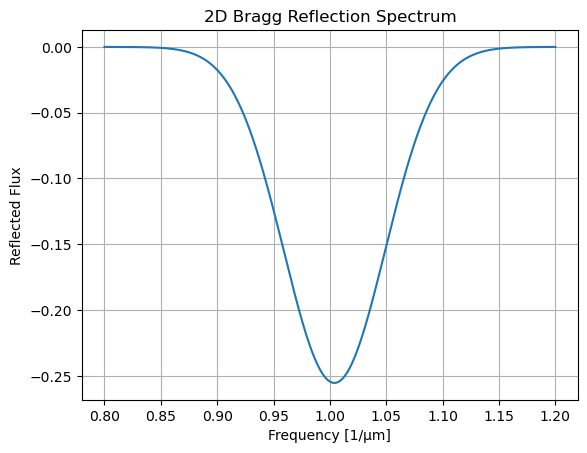

In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from meep.materials import Si

# 参数定义
resolution = 60  # 每 micron 像素数
dp = 0.427       # 一个周期 = 0.25 (air) + 0.177 (Si)
num_periods = 20
sz = dp * num_periods + 4.0  # 加两边空白区
sx = 5.0                     # 横向足够大以模拟平面波

cell = mp.Vector3(sx, sz)

# 材料定义
air = mp.Medium(index=1.0)
si = mp.Medium(index=1.41)

# 光源参数
lambda0 = 1
freq0 = 1 / lambda0
df = 0.4 * freq0

sources = [mp.Source(mp.GaussianSource(frequency=freq0, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(0, -0.5 * sz + 0.5),
                     size=mp.Vector3(sx, 0))]

geometry = []

# PML 区域
pml_layers = [mp.PML(1.0)]

sim = mp.Simulation(
    cell_size=cell,
    geometry=geometry,
    sources=sources,
    boundary_layers=pml_layers,
    resolution=resolution,
    dimensions=2,
)

# 添加反射探测器
refl_region = mp.FluxRegion(center=mp.Vector3(0, -0.5 * sz + 0.8), size=mp.Vector3(sx, 0))
refl_flux = sim.add_flux(freq0, df, 500, refl_region)
tran_region = mp.FluxRegion(center=mp.Vector3(0, 0.5 * sz - 0.8), size=mp.Vector3(sx,0))
tran_flux = sim.add_flux(freq0, df, 500, tran_region)
sim.run(until=200)
# === 保存 incident flux 数据，用于后续结构仿真中减去 ===
incident_flux = mp.get_fluxes(refl_flux)
incident_data = sim.get_flux_data(refl_flux)

# 周期性结构
z0 = -0.5 * sz + 1.0
for i in range(num_periods):
    geometry.append(mp.Block(center=mp.Vector3(0, z0 + 0.125),
                             size=mp.Vector3(mp.inf, 0.25),
                             material=air))
    z0 += 0.25
    geometry.append(mp.Block(center=mp.Vector3(0, z0 + 0.0885),
                             size=mp.Vector3(mp.inf, 0.177),
                             material=si))
    z0 += 0.177
sim_grating = mp.Simulation(
    cell_size=cell,
    geometry=geometry,
    sources=sources,
    boundary_layers=pml_layers,
    resolution=resolution,
    dimensions=2,
)
# 添加反射探测器
refl_region = mp.FluxRegion(center=mp.Vector3(0, -0.5 * sz + 0.8), size=mp.Vector3(sx, 0))
refl_flux = sim_grating.add_flux(freq0, df, 500, refl_region)
tran_region = mp.FluxRegion(center=mp.Vector3(0, 0.5 * sz - 0.8), size=mp.Vector3(sx,0))
tran_flux = sim_grating.add_flux(freq0, df, 500, tran_region)
sim.run(until=200)
# === 保存 incident flux 数据，用于后续结构仿真中减去 ===
with_grating_flux = mp.get_fluxes(refl_flux)
with_grating_data = sim.get_flux_data(refl_flux)
sim_grating.run(until=200)
sim_grating.plot2D()

plt.figure()
# 获取频率和反射能量
freqs = mp.get_flux_freqs(refl_flux)
reflect_flux = [x - y for x, y in zip(with_grating_flux,incident_flux)]
sim.load_minus_flux_data
# 绘制反射谱
plt.plot(freqs, reflect_flux)
plt.xlabel("Frequency [1/μm]")
plt.ylabel("Reflected Flux")
plt.title("2D Bragg Reflection Spectrum")
plt.grid(True)
plt.show()


### change structure
- Using the aperiodic structure to simulation on the Bragg reflection
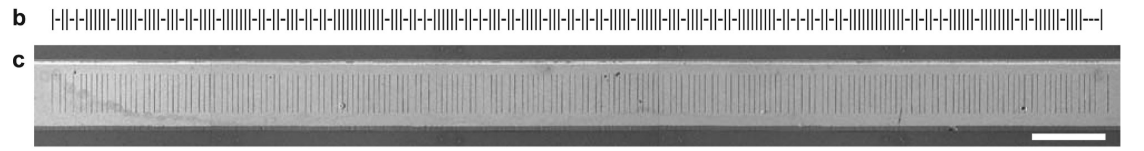

     block, center = (0,0,0)
          size (1e+20,18,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.9881,1.9881,1.9881)
     block, center = (0,-117.25,0)
          size (1e+20,0.1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-115.75,0)
          size (1e+20,0.1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-114.75,0)
          size (1e+20,0.1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-113.75,0)
          size (1e+20,0.1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-112.25,0)
          size (1e+20,0.1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center =

<Axes: xlabel='X', ylabel='Y'>

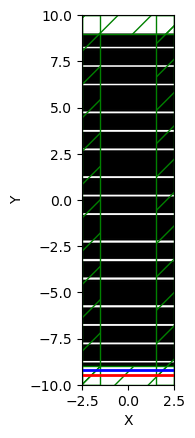

In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
# from meep.materials import Si

# 参数定义
resolution = 50  # 每 micron 像素数
# dp = 0.427       # 一个周期 = 0.25 (air) + 0.177 (Si)
# num_periods = 8
# sz = dp * num_periods + 4.0  # 加两边空白区
sx = 5.0                     # 横向足够大以模拟平面波

# 材料定义
air = mp.Medium(index=1.0)
si = mp.Medium(index=1.41)

# 周期性结构
pattern_1 = "|-||-|-||||||-|||||-||||-|||-||-||||-|||||||-||-||-|||-||-|-||-|||-||-|-||||||-||-|-|||-||-|||||-|||-||-|"
pattern_2 = "|-||-|||||-||||||-|||-||||-||-||-|||||||||-||-|-||-||-||-|-|||-||-||-|-||||||-||||||||-||-||||||-||||---|"
pattern = pattern_1 + pattern_2

line = 1
dash = line * 1.5
sz_length = 0
for symbol in pattern:
    sz_length += line if symbol == '|' else dash
sz= sz_length + 1.0
sz = 20
z_start = -sz_length/2
z_pos = z_start
z0 = -0.5 * sz - 1.0
cell = mp.Vector3(sx, sz)

def add_grating(pattern:list,grating_geometry:list):
    """ add grating structure through z axis"""
    global z_pos
    for symbol in pattern:
        z_pos = z_pos + line if symbol == "|" else z_pos + dash
        grating_geometry.append(mp.Block(material=air,
                                         center=mp.Vector3(0,z_pos),
                                         size=mp.Vector3(mp.inf,0.1),
                                         ))

geometry = []
geometry.append(mp.Block(material=si,
                         center=mp.Vector3(0,0),
                         size=mp.Vector3(mp.inf,sz-2),
                                         ))

add_grating(pattern,geometry)


# 光源参数
lambda0 = 1.0
freq0 = 1 / lambda0
df = 0.4 * freq0

sources = [mp.Source(mp.GaussianSource(frequency=freq0, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(0, -0.5 * sz + 0.5),
                     size=mp.Vector3(sx, 0))]

# PML 区域
pml_layers = [mp.PML(1.0)]

sim = mp.Simulation(
    cell_size=cell,
    geometry=geometry,
    sources=sources,
    boundary_layers=pml_layers,
    resolution=resolution,
    dimensions=2,
)

# 添加反射探测器
refl_fr = mp.FluxRegion(center=mp.Vector3(0, -0.5 * sz + 0.8), size=mp.Vector3(sx, 0))
refl = sim.add_flux(freq0, df, 500, refl_fr)
sim.plot2D()

# sim.run(until=200)

# plt.figure()
# # 获取频率和反射能量
# freqs = mp.get_flux_freqs(refl)
# refl_data = mp.get_fluxes(refl)

# # 绘制反射谱
# plt.plot(freqs, refl_data)
# plt.xlabel("Frequency [1/μm]")
# plt.ylabel("Reflected Flux")
# plt.title("2D Bragg Reflection Spectrum")
# plt.grid(True)
# plt.show()


## Using the holey function to construct structure
---

### holey-wvg-cavity.py
- This is the completely copy of the holey-wve-cavity in meep tutorial.

     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (2.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-2.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant eps

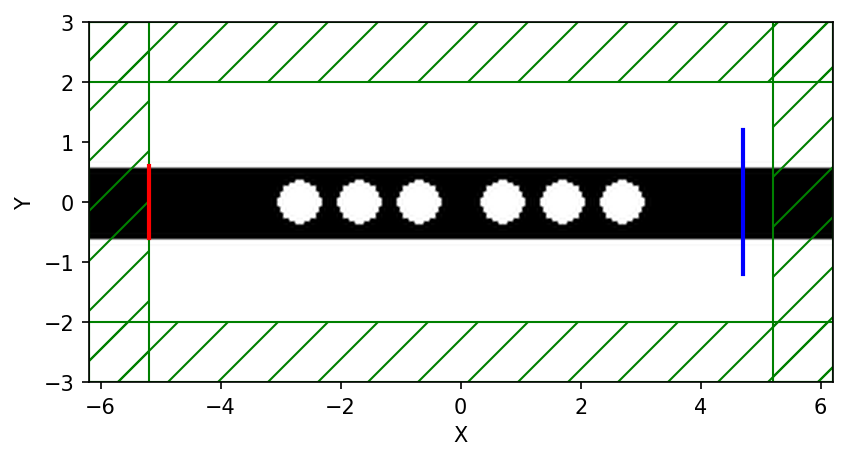

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.000880957 s
Working in 2D dimensions.
Computational cell is 12.4 x 6 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (2.7,0,0)
          radius 0.3

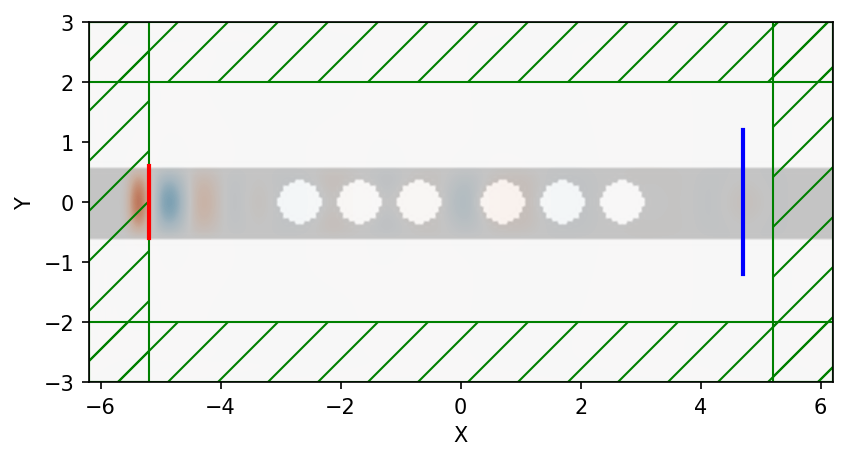

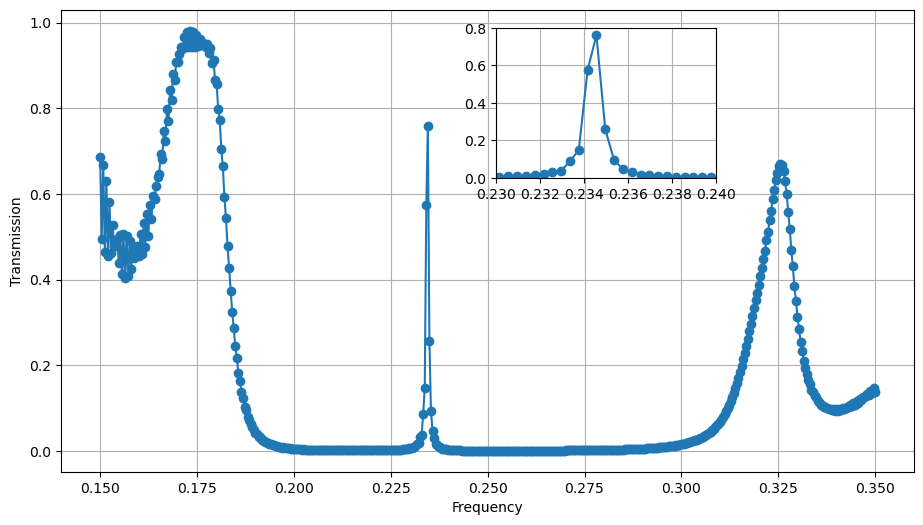

In [1]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Video

resolution = 20  # pixels/um

eps = 13  # dielectric constant of waveguide
w = 1.2  # width of waveguide
r = 0.36  # radius of holes
d = 1.4  # defect spacing (ordinary spacing = 1)
N = 3  # number of holes on either side of defect

sy = 6  # size of cell in y direction (perpendicular to wvg.)
pad = 2  # padding between last hole and PML edge
dpml = 1  # PML thickness

sx = 2 * (pad + dpml + N) + d - 1  # size of cell in x direction
cell = mp.Vector3(sx, sy, 0)

blk = mp.Block(size=mp.Vector3(mp.inf, w, mp.inf), material=mp.Medium(epsilon=eps))
geometry = [blk]

for i in range(N):
    geometry.append(mp.Cylinder(r, center=mp.Vector3(d / 2 + i)))
    geometry.append(mp.Cylinder(r, center=mp.Vector3(-(d / 2 + i))))
    
pml_layers = [mp.PML(1.0)]
fcen = 0.25  # pulse center frequency
df = 0.2  # pulse frequency width

src = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ey,
        center=mp.Vector3(-0.5 * sx + dpml),
        size=mp.Vector3(0, w),
    )
]

sym = [mp.Mirror(mp.Y, phase=-1)]

sim = mp.Simulation(
    cell_size=cell,
    geometry=geometry,
    boundary_layers=pml_layers,
    sources=src,
    symmetries=sym,
    resolution=resolution,
)

freg = mp.FluxRegion(
    center=mp.Vector3(0.5 * sx - dpml - 0.5), size=mp.Vector3(0, 2 * w)
)

nfreq = 500  # number of frequencies at which to compute flux

# transmitted flux
trans = sim.add_flux(fcen, df, nfreq, freg)

f = plt.figure(dpi=150)
sim.plot2D(ax=f.gca())
plt.show()

f = plt.figure(dpi=150)
animate = mp.Animate2D(f=f, fields=mp.Hz, realtime=False, normalize=True)

sim.run(
    mp.during_sources(mp.at_every(0.4, animate)),
    until_after_sources=mp.stop_when_fields_decayed(
        50, mp.Ey, mp.Vector3(0.5 * sx - dpml - 0.5), 1e-3
    ),
)
# plt.close()

filename = "media/hole-wvg-cavity.mp4"
try:
    animate.to_mp4(10, "my_sim.mp4")
except Exception as e:
    print("动画导出失败，跳过。错误信息:", e)
# Video("my_sim.mp4")

def sim_cavity(N=3, sy=6):
    sx = 2 * (pad + dpml + N) + d - 1  # size of cell in x direction
    cell = mp.Vector3(sx, sy, 0)
    blk = mp.Block(size=mp.Vector3(mp.inf, w, mp.inf), material=mp.Medium(epsilon=eps))
    geometry = [blk]

    for i in range(N):
        geometry.append(mp.Cylinder(r, center=mp.Vector3(d / 2 + i)))
        geometry.append(mp.Cylinder(r, center=mp.Vector3(-(d / 2 + i))))

    src = [
        mp.Source(
            mp.GaussianSource(fcen, fwidth=df),
            component=mp.Ey,
            center=mp.Vector3(-0.5 * sx + dpml),
            size=mp.Vector3(0, w),
        )
    ]

    sim = mp.Simulation(
        cell_size=cell,
        geometry=geometry,
        boundary_layers=pml_layers,
        sources=src,
        symmetries=sym,
        resolution=resolution,
    )

    freg = mp.FluxRegion(
        center=mp.Vector3(0.5 * sx - dpml - 0.5), size=mp.Vector3(0, 2 * w)
    )
    nfreq = 500
    trans = sim.add_flux(fcen, df, nfreq, freg)

    sim.run(
        until_after_sources=mp.stop_when_fields_decayed(
            50, mp.Ey, mp.Vector3(0.5 * sx - dpml - 0.5), 1e-3
        )
    )

    freqs = mp.get_flux_freqs(trans)
    psd = mp.get_fluxes(trans)

    return freqs, psd

freqs_wg, psd_wg = sim_cavity(N=0)  # simple waveguide
freqs_cav, psd_cav = sim_cavity()  # cavity

fig = plt.figure(figsize=(11, 6), dpi=100)
ax = fig.add_subplot(111)
plt.plot(freqs_cav, np.array(psd_cav) / np.array(psd_wg), "o-")
plt.grid(True)
plt.xlabel("Frequency")
plt.ylabel("Transmission")

ax2 = fig.add_axes([0.52, 0.6, 0.2, 0.25])
plt.plot(freqs_cav, np.array(psd_cav) / np.array(psd_wg), "o-")
plt.xlim(0.23, 0.24)
plt.ylim(0, 0.8)
plt.grid(True)
plt.show()

### Code modification
- Modify the grating structure into aperiodic structure.
- As the length becomes long, the wave becomes hard to tramsmission.
- With default material in meep, the wave with frequency of THz can not spread when length exceeds 70um.


     block, center = (0,0,0)
          size (1e+20,1.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (-119.75,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-118.25,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-117.25,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-116.25,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-114.75,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-113.75,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          di

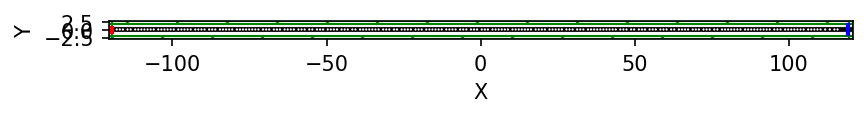

<Figure size 960x720 with 0 Axes>

In [33]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Video

resolution = 20  # pixels/um

eps = 13  # dielectric constant of waveguide
w = 1.5  # width of waveguide
r = 0.36  # radius of holes
d = 1.4  # defect spacing (ordinary spacing = 1)
N = 3  # number of holes on either side of defect

sy = 6  # size of cell in y direction (perpendicular to wvg.)
pad = 2  # padding between last hole and PML edge
dpml = 1  # PML thickness

# sx = 2 * (pad + dpml + N) + d - 1  # size of cell in x direction

blk = mp.Block(size=mp.Vector3(mp.inf, w, mp.inf), material=mp.Medium(epsilon=eps))
geometry = [blk]

pattern_1 = "|-||-|-||||||-|||||-||||-|||-||-||||-|||||||-||-||-|||-||-|-||-|||-||-|-||||||-||-|-|||-||-|||||-|||-||-|"
pattern_2 = "|-||-|||||-||||||-|||-||||-||-||-|||||||||-||-|-||-||-||-|-|||-||-||-|-||||||-||||||||-||-||||||-||||---|"
pattern = pattern_1 + pattern_2
slot_depth = 50
slot_width = 0.1
line = 1
dash = line * 1.5
sx_length = 0
for symbol in pattern:
    sx_length += line if symbol == '|' else dash

sx = sx_length+5
cell = mp.Vector3(sx, sy, 0)
x_pos = -sx/2
def add_holes(pattern:list,grating_geometry:list):
    """ add grating structure through z axis"""
    global x_pos
    for symbol in pattern:
        x_pos = x_pos + line if symbol == "|" else x_pos + dash
        grating_geometry.append(mp.Cylinder(r, center=mp.Vector3(x_pos)))

# for i in range(N):
#     geometry.append(mp.Cylinder(r, center=mp.Vector3(d / 2 + i)))
#     geometry.append(mp.Cylinder(r, center=mp.Vector3(-(d / 2 + i))))

add_holes(pattern,geometry)

pml_layers = [mp.PML(1.0)]
c = 3e8
frequency = 5e12
freq_in_meep = frequency * 1e-6 / 3e8 # 5THz
wavelength = c/frequency
df = 0.2  # pulse frequency width

src = [
    mp.Source(
        mp.ContinuousSource(freq_in_meep, fwidth=df),
        component=mp.Ey,
        center=mp.Vector3(-0.5 * sx + dpml),
        size=mp.Vector3(0, w),
    )
]

# sym = [mp.Mirror(mp.Y, phase=-1)]

sim = mp.Simulation(
    cell_size=cell,
    geometry=geometry,
    boundary_layers=pml_layers,
    sources=src,
    # symmetries=sym,
    resolution=resolution,
)

freg = mp.FluxRegion(
    center=mp.Vector3(0.5 * sx - dpml - 0.5), size=mp.Vector3(0, 2 * w)
)

nfreq = 500  # number of frequencies at which to compute flux

# transmitted flux
trans = sim.add_flux(fcen, df, nfreq, freg)

f = plt.figure(dpi=150)
sim.plot2D(ax=f.gca())
plt.show()

f = plt.figure(dpi=150)
# animate = mp.Animate2D(f=f, fields=mp.Hz, realtime=False, normalize=True)

# sim.run(
#     mp.during_sources(mp.at_every(0.4, animate)),
#     until_after_sources=mp.stop_when_fields_decayed(
#         50, mp.Ey, mp.Vector3(0.5 * sx - dpml - 0.5), 1e-3))

# try:
#     animate.to_mp4(10, "my_sim.mp4")
# except Exception as e:
#     print("anime output fail, skip, the error information is ", e)
# Video("my_sim.mp4")

#### Plot the flux using the aperiodic grating structure and original material
---

In [ ]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Video

def sim_cavity(N,sx,sy=6,fcen=10):
    resolution = 20  # pixels/um

    eps = 13  # dielectric constant of waveguide
    w = 1.2  # width of waveguide
    r = 0.36  # radius of holes
    d = 1.4  # defect spacing (ordinary spacing = 1)
    N = N  # number of holes on either side of defect

    pad = 2  # padding between last hole and PML edge
    dpml = 1  # PML thickness

    # sx = 2 * (pad + dpml + N) + d - 1  # size of cell in x direction
    
    cell = mp.Vector3(sx, sy, 0)
    blk = mp.Block(size=mp.Vector3(mp.inf, w, mp.inf), material=mp.Medium(epsilon=eps))
    ###---------------------------------------------------------------basic config-------------------------------------------------------------------###

    ###-------------------------------------------------------------geometry---------------------------------------------------------------------###
    geometry = [blk]
    # Substrate

    ###-------------------------------------------------------------grating parameters---------------------------------------------------------------------###
    pattern_1 = "|-||-|-||||||-|||||-||||-|||-||-||||-|||||||-||-||-|||-||-|-||-|||-||-|-||||||-||-|-|||-||-|||||-|||-||-|"
    pattern_2 = "|-||-|||||-||||||-|||-||||-||-||-|||||||||-||-|-||-||-||-|-|||-||-||-|-||||||-||||||||-||-||||||-||||---|"
    pattern = pattern_1 + pattern_2

    if N == 0:
        for i in range(N):
            geometry.append(mp.Cylinder(r, center=mp.Vector3(d / 2 + i)))
            geometry.append(mp.Cylinder(r, center=mp.Vector3(-(d / 2 + i))))
    else:
        for i, symbol in enumerate(pattern):
            if symbol == "|":
                x_pos = -sx/2 + i * d
                geometry.append(mp.Cylinder(r, center=mp.Vector3(x_pos)))
            else:
                x_pos = -sx/2 + i * d * 0.5

    pml_layers = [mp.PML(1.0)]
    # fcen = 0.25  # pulse center frequency
    df = 0.2  # pulse frequency width

    src = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
            component=mp.Ey,
            center=mp.Vector3(-0.5 * sx + dpml),
            size=mp.Vector3(0, w))]

    # sym = [mp.Mirror(mp.Y, phase=-1)]
    ###-------------------------------------------------------------simulation setup---------------------------------------------------------------------###
    sim = mp.Simulation(
        cell_size=cell,
        geometry=geometry,
        boundary_layers=pml_layers,
        sources=src,
        # symmetries=sym,
        resolution=resolution)
    
    freg = mp.FluxRegion(
        center=mp.Vector3(0.5 * sx - dpml - 0.5), size=mp.Vector3(0, 2 * w))

    nfreq = 100  # number of frequencies at which to compute flux

    # transmitted flux
    trans = sim.add_flux(fcen, df, nfreq, freg)
    sim.plot2D()
    sim.run(until_after_sources=mp.stop_when_fields_decayed(
            50, mp.Ey, mp.Vector3(0.5 * sx - dpml), 1e-3))

    freqs = mp.get_flux_freqs(trans)
    psd = mp.get_fluxes(trans)

    return freqs, psd

sx_main = 60
sy_main = 6
fcen_main = 1e12

freqs_wg, psd_wg = sim_cavity(N=0,sx = sx_main,fcen=fcen_main)  # simple waveguide
freqs_cav, psd_cav = sim_cavity(N=1,sx = sx_main,fcen=fcen_main)  # cavity

fig = plt.figure(figsize=(11, 6), dpi=100)
ax = fig.add_subplot(111)
plt.plot(freqs_cav, np.array(psd_cav) / np.array(psd_wg), "o-")
plt.grid(True)
plt.xlabel("Frequency")
plt.ylabel("Transmission")

# ax2 = fig.add_axes([0.52, 0.6, 0.2, 0.25])
# plt.plot(freqs_cav, np.array(psd_cav) / np.array(psd_wg), "o-")
# plt.xlim(0.23, 0.24)
# plt.ylim(0, 0.8)
# plt.grid(True)
# plt.show()

### Modify the materials of the structure
- Using the follow materials structure and aperiodic grating to plot the flux of the wave.
- 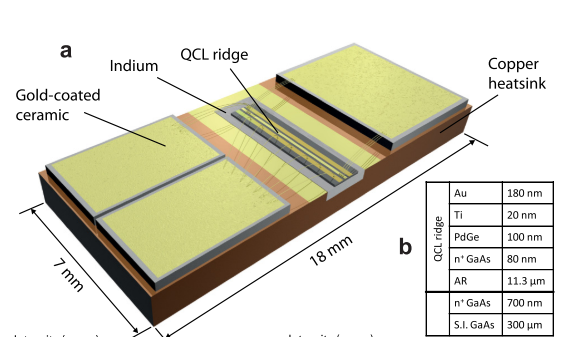
- The simulation is running in 2 dimensions, with the height in y axis and length in x axis.  

In [ ]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
from meep.materials import Au

def sim_cavity(N,sx,sy=10,fcen=10):
    resolution = 20  # pixels/um

    eps = 13  # dielectric constant of waveguide
    w = 1.2  # width of waveguide
    r = 0.15  # radius of holes
    d = 1  # defect spacing (ordinary spacing = 1)
    N = N  # number of holes on either side of defect

    pad = 2  # padding between last hole and PML edge
    dpml = 1  # PML thickness
    
    # sx = 2 * (pad + dpml + N) + d - 1  # size of cell in x direction
    
    cell = mp.Vector3(sx, sy, 0)
    sy = sy - dpml*2
    ###---------------------------------------------------------------basic config-------------------------------------------------------------------###
    # thickness of different layers（1 μm）
    au_thickness = 0.18
    ngaas_thickness_1 = 0.08
    Active_region_thickness = 0.0113
    ngaas_thickness_2 = 0.7
    sigaas_thickness = 5
    w = au_thickness + ngaas_thickness_1 + Active_region_thickness + ngaas_thickness_2 + sigaas_thickness # width of waveguide
    blk = mp.Block(size=mp.Vector3(mp.inf, w, mp.inf), material=mp.Medium(epsilon=eps))

    # material definition
    Active_region = mp.air
    # Au = mp.Medium(epsilon=1.0, D_conductivity=1e7)
    GaAs_low_doped = mp.Medium(epsilon=12.9, D_conductivity=0)
    GaAs_high_doped = mp.Medium(epsilon=5, D_conductivity=100)

    n_GaAs = mp.Medium(
        epsilon=10.9,  # 高频极限介电常数
        E_susceptibilities=[
            mp.DrudeSusceptibility(
                frequency=0.37,
                gamma=0.01,
                sigma=1.0
            )])
    ###-------------------------------------------------------------geometry---------------------------------------------------------------------###
    geometry = []
    # Substrate
    geometry.append(mp.Block(
                        material=GaAs_low_doped,
                        size=mp.Vector3(mp.inf,sigaas_thickness,mp.inf),
                        center=mp.Vector3(y = -sy/2 + sigaas_thickness/2)))

    geometry.append(mp.Block(
                        material=GaAs_high_doped,
                        size=mp.Vector3(mp.inf,ngaas_thickness_2,mp.inf),
                        center=mp.Vector3(y= -sy/2 + sigaas_thickness + ngaas_thickness_2/2)))

    # QCL active region
    geometry.append(mp.Block(
                        material=n_GaAs,
                        size=mp.Vector3(mp.inf,Active_region_thickness,mp.inf),
                        center=mp.Vector3(y= -sy/2 + sigaas_thickness + ngaas_thickness_2 + Active_region_thickness/2)))

    # upper layers
    y0 = -sy/2 + sigaas_thickness + ngaas_thickness_2 + Active_region_thickness
    geometry += [
        mp.Block(material = GaAs_high_doped, 
                size = mp.Vector3(mp.inf,ngaas_thickness_1,mp.inf), 
                center = mp.Vector3(y = y0 + ngaas_thickness_1/2)),
        mp.Block(material = Au,    
                size = mp.Vector3(mp.inf,au_thickness,mp.inf),    
                center = mp.Vector3(y = y0 + ngaas_thickness_1 + au_thickness/2))]

    ###-------------------------------------------------------------grating parameters---------------------------------------------------------------------###
    pattern_1 = "|-||-|-||||||-|||||-||||-|||-||-||||-|||||||-||-||-|||-||-|-||-|||-||-|-||||||-||-|-|||-||-|||||-|||-||-|"
    pattern_2 = "|-||-|||||-||||||-|||-||||-||-||-|||||||||-||-|-||-||-||-|-|||-||-||-|-||||||-||||||||-||-||||||-||||---|"
    pattern = pattern_1 + pattern_2

    if N == 0:
        pass
    else:
        for i, symbol in enumerate(pattern):
            if symbol == "|":
                x_pos = -sx/2 + i * d
                geometry.append(mp.Cylinder(r, center=mp.Vector3(x=x_pos,y=y0 + ngaas_thickness_1 + au_thickness/2)))
            else:
                x_pos = -sx/2 + i * d * 0.5

    pml_layers = [mp.PML(1.0)]
    # fcen = 0.25  # pulse center frequency
    df = 0.2  # pulse frequency width

    src = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
            component=mp.Ey,
            center=mp.Vector3(-0.5 * sx + dpml),
            size=mp.Vector3(0, sy))]

    # sym = [mp.Mirror(mp.Y, phase=-1)]
    ###-------------------------------------------------------------simulation setup---------------------------------------------------------------------###
    sim = mp.Simulation(
        cell_size=cell,
        geometry=geometry,
        boundary_layers=pml_layers,
        sources=src,
        # symmetries=sym,
        resolution=resolution)

    freg = mp.FluxRegion(
        center=mp.Vector3(0.5 * sx - dpml - 0.5), size=mp.Vector3(0, sy))

    nfreq = 100  # number of frequencies at which to compute flux

    # transmitted flux
    trans = sim.add_flux(fcen, df, nfreq, freg)

    sim.plot2D()
    sim.run(until_after_sources=mp.stop_when_fields_decayed(
            50, mp.Ey, mp.Vector3(0.5 * sx - dpml), 1e-3))

    freqs = mp.get_flux_freqs(trans)
    psd = mp.get_fluxes(trans)

    return freqs, psd

sx_main = 60
sy_main = 6
fcen_main = 1e12

freqs_wg, psd_wg = sim_cavity(N=0,sx = sx_main,fcen=fcen_main)  # simple waveguide
freqs_cav, psd_cav = sim_cavity(N=1,sx = sx_main,fcen=fcen_main)  # cavity

fig = plt.figure(figsize=(11, 6), dpi=100)
ax = fig.add_subplot(111)
plt.plot(freqs_cav, np.array(psd_cav) / np.array(psd_wg), "o-")
plt.grid(True)
plt.xlabel("Frequency")
plt.ylabel("Transmission")

# ax2 = fig.add_axes([0.52, 0.6, 0.2, 0.25])
# plt.plot(freqs_cav, np.array(psd_cav) / np.array(psd_wg), "o-")
# plt.xlim(0.23, 0.24)
# plt.ylim(0, 0.8)
# plt.grid(True)
# plt.show()

### Plot the flux with default material （epsilon = 13） and no holes 
---


     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00037694 s
Working in 2D dimensions.
Computational cell is 60 x 6 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
time for set_epsilon = 0.155535 s
-----------
field decay(t = 50.025000000000006): 1.7593202174750258e-209 / 1.7593202174750258e-209 = 1.0
field decay(t = 100.05000000000001): 1.068218675453996e-34 / 1.068218675453996e-34 = 1.0
field decay(t = 150.07500000000002): 5.500216913935622e-35 / 1.068218675453996e-34 = 0.5148961575304808
field decay(t = 200.10000000000002): 4.597607183910415e-35 / 1.068218675453996e-34 = 0.4303994387625192
on time step 8358 (time=208.95), 0.000478592 s/step
field decay(t = 250.125):

Text(0, 0.5, 'Transmission')

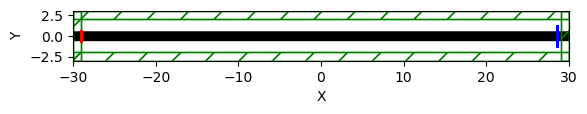

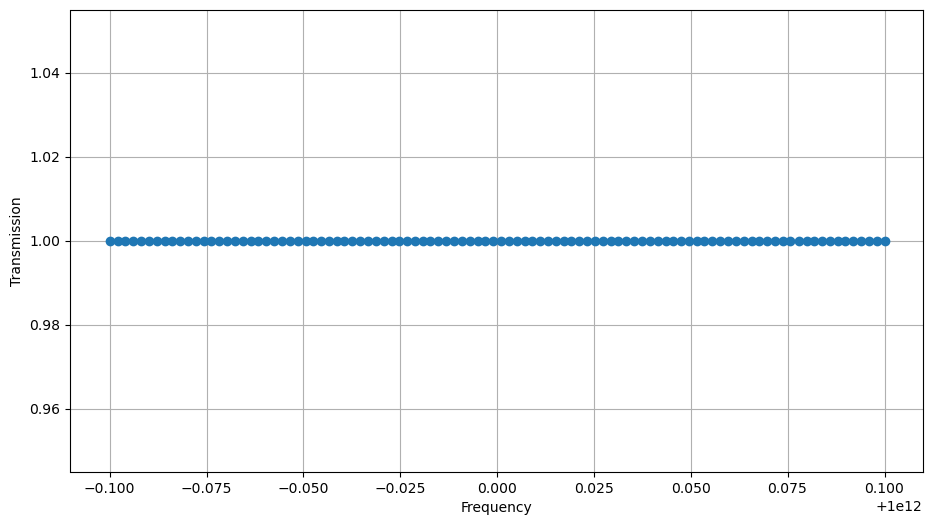

In [1]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Video

def sim_cavity(N,sx,sy=6,fcen=10):
    resolution = 20  # pixels/um

    eps = 13  # dielectric constant of waveguide
    w = 1.2  # width of waveguide
    r = 0.36  # radius of holes
    d = 1.4  # defect spacing (ordinary spacing = 1)
    N = N  # number of holes on either side of defect

    pad = 2  # padding between last hole and PML edge
    dpml = 1  # PML thickness

    # sx = 2 * (pad + dpml + N) + d - 1  # size of cell in x direction
    
    cell = mp.Vector3(sx, sy, 0)
    blk = mp.Block(size=mp.Vector3(mp.inf, w, mp.inf), material=mp.Medium(epsilon=eps))
    ###---------------------------------------------------------------basic config-------------------------------------------------------------------###

    ###-------------------------------------------------------------geometry---------------------------------------------------------------------###
    geometry = [blk]


    pml_layers = [mp.PML(1.0)]
    # fcen = 0.25  # pulse center frequency
    df = 0.2  # pulse frequency width

    src = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
            component=mp.Ey,
            center=mp.Vector3(-0.5 * sx + dpml),
            size=mp.Vector3(0, w))]

    # sym = [mp.Mirror(mp.Y, phase=-1)]
    ###-------------------------------------------------------------simulation setup---------------------------------------------------------------------###
    sim = mp.Simulation(
        cell_size=cell,
        geometry=geometry,
        boundary_layers=pml_layers,
        sources=src,
        # symmetries=sym,
        resolution=resolution)
    
    freg = mp.FluxRegion(
        center=mp.Vector3(0.5 * sx - dpml - 0.5), size=mp.Vector3(0, 2 * w))

    nfreq = 100  # number of frequencies at which to compute flux

    # transmitted flux
    trans = sim.add_flux(fcen, df, nfreq, freg)
    sim.plot2D()
    sim.run(until_after_sources=mp.stop_when_fields_decayed(
            50, mp.Ey, mp.Vector3(0.5 * sx - dpml), 1e-3))

    freqs = mp.get_flux_freqs(trans)
    psd = mp.get_fluxes(trans)

    return freqs, psd

sx_main = 60
sy_main = 6
fcen_main = 1e12

freqs_wg, psd_wg = sim_cavity(N=0,sx = sx_main,fcen=fcen_main)  # simple waveguide
freqs_cav, psd_cav = sim_cavity(N=1,sx = sx_main,fcen=fcen_main)  # cavity

fig = plt.figure(figsize=(11, 6), dpi=100)
ax = fig.add_subplot(111)
plt.plot(freqs_cav, np.array(psd_cav) / np.array(psd_wg), "o-")
plt.grid(True)
plt.xlabel("Frequency")
plt.ylabel("Transmission")

# ax2 = fig.add_axes([0.52, 0.6, 0.2, 0.25])
# plt.plot(freqs_cav, np.array(psd_cav) / np.array(psd_wg), "o-")
# plt.xlim(0.23, 0.24)
# plt.ylim(0, 0.8)
# plt.grid(True)
# plt.show()

### Plot the result with air material (epsilon = 1)
---

     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 2D dimensions.
Computational cell is 60 x 6 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.131492 s
-----------
field decay(t = 50.025000000000006): 1.0092168053256717e-166 / 1.0092168053256717e-166 = 1.0
field decay(t = 100.05000000000001): 1.338886846984617e-30 / 1.338886846984617e-30 = 1.0
field decay(t = 150.07500000000002): 1.877473626423581e-30 / 1.877473626423581e-30 = 1.0
field decay(t = 200.10000000000002): 3.0969037361472207e-31 / 1.877473626423581e-30 = 0.16495058532707832
on time step 9478 (time=236.95), 0.000422039 s/step
field decay(t = 250.125): 1.981374365456267

Text(0, 0.5, 'Transmission')

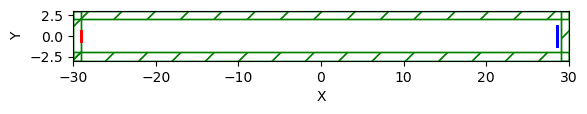

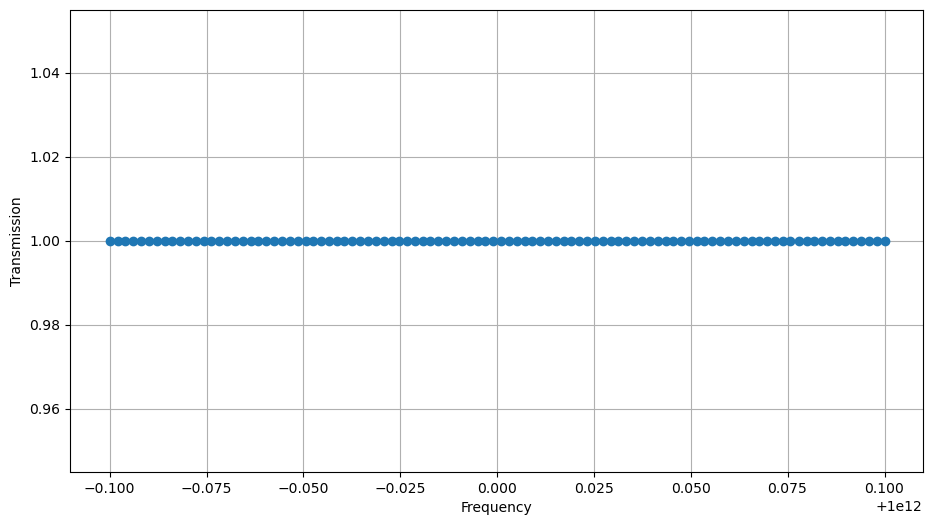

In [2]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Video

def sim_cavity(N,sx,sy=6,fcen=10):
    resolution = 20  # pixels/um

    eps = 1  # dielectric constant of waveguide
    w = 1.2  # width of waveguide
    r = 0.36  # radius of holes
    d = 1.4  # defect spacing (ordinary spacing = 1)
    N = N  # number of holes on either side of defect

    pad = 2  # padding between last hole and PML edge
    dpml = 1  # PML thickness

    # sx = 2 * (pad + dpml + N) + d - 1  # size of cell in x direction
    
    cell = mp.Vector3(sx, sy, 0)
    blk = mp.Block(size=mp.Vector3(mp.inf, w, mp.inf), material=mp.Medium(epsilon=eps))
    ###---------------------------------------------------------------basic config-------------------------------------------------------------------###

    ###-------------------------------------------------------------geometry---------------------------------------------------------------------###
    geometry = [blk]


    pml_layers = [mp.PML(1.0)]
    # fcen = 0.25  # pulse center frequency
    df = 0.2  # pulse frequency width

    src = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
            component=mp.Ey,
            center=mp.Vector3(-0.5 * sx + dpml),
            size=mp.Vector3(0, w))]

    # sym = [mp.Mirror(mp.Y, phase=-1)]
    ###-------------------------------------------------------------simulation setup---------------------------------------------------------------------###
    sim = mp.Simulation(
        cell_size=cell,
        geometry=geometry,
        boundary_layers=pml_layers,
        sources=src,
        # symmetries=sym,
        resolution=resolution)
    
    freg = mp.FluxRegion(
        center=mp.Vector3(0.5 * sx - dpml - 0.5), size=mp.Vector3(0, 2 * w))

    nfreq = 100  # number of frequencies at which to compute flux

    # transmitted flux
    trans = sim.add_flux(fcen, df, nfreq, freg)
    sim.plot2D()
    sim.run(until_after_sources=mp.stop_when_fields_decayed(
            50, mp.Ey, mp.Vector3(0.5 * sx - dpml), 1e-3))

    freqs = mp.get_flux_freqs(trans)
    psd = mp.get_fluxes(trans)

    return freqs, psd

sx_main = 60
sy_main = 6
fcen_main = 1e12

freqs_wg, psd_wg = sim_cavity(N=0,sx = sx_main,fcen=fcen_main)  # simple waveguide
freqs_cav, psd_cav = sim_cavity(N=1,sx = sx_main,fcen=fcen_main)  # cavity

fig = plt.figure(figsize=(11, 6), dpi=100)
ax = fig.add_subplot(111)
plt.plot(freqs_cav, np.array(psd_cav) / np.array(psd_wg), "o-")
plt.grid(True)
plt.xlabel("Frequency")
plt.ylabel("Transmission")

# ax2 = fig.add_axes([0.52, 0.6, 0.2, 0.25])
# plt.plot(freqs_cav, np.array(psd_cav) / np.array(psd_wg), "o-")
# plt.xlim(0.23, 0.24)
# plt.ylim(0, 0.8)
# plt.grid(True)
# plt.show()

### From Haitao Wang


-----------
Initializing structure...
time for choose_chunkdivision = 0.000626087 s
Working in 3D dimensions.
Computational cell is 0.0555556 x 2.16667 x 59.8333 with resolution 18
     block, center = (0,-0.275,0)
          size (1e+20,0.00181818,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.205909,0)
          size (1e+20,0.136364,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.96,12.96,12.96)
     block, center = (0,-0.133182,0)
          size (1e+20,0.00909091,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.96,12.96,12.96)
     block, center = (0,-0.0772727,0)
          size (1e+20,0.102727,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.96,12.96,12.96)
     block, center = (0,-0.025,0)
          size (1e+20,0.00181818,1e+20)
          axes 

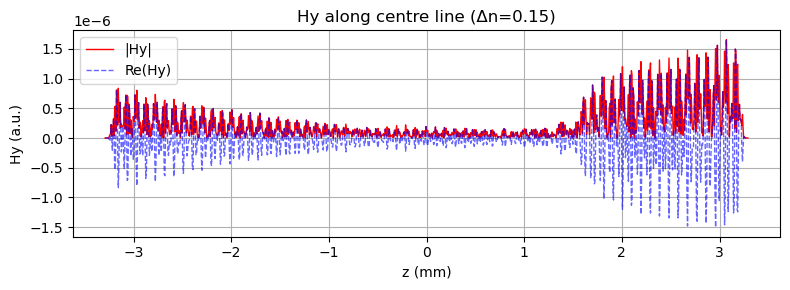

>>> cell_z = 59.83 sim-units ≈ 6.58 mm (< 7 mm)


NameError: name 'sx' is not defined

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
229-bit holey-waveguide DFB  –  折射率微扰版 (Δn≈0.15)
TE (Ex) 激励，提取 Hy(z)；总长 ≈ 6.9 mm
修正了 Block() 参数传递方式，确保各段 geometry 正确生成。
"""

import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1. 基本单位 ----------
lam0 = 1.0           # 1 sim-unit = 110 µm
µm   = 1/110.0       # 1 µm = 0.00909 sim-unit

# ---------- 2. 材料 ----------
n_hi, n_lo = 3.60, 3.45       # Δn = 0.15
GaAs_hi = mp.Medium(index=n_hi)
GaAs_lo = mp.Medium(index=n_lo)
GaAs_nP = mp.Medium(index=n_hi, D_conductivity=5e3)
Au = mp.Medium(epsilon=1.0,
    E_susceptibilities=[mp.DrudeSusceptibility(frequency=45.7,
                                              gamma=0.357,
                                              sigma=1.0)])

# ---------- 3. 层厚度 ----------
t_met, t_AR, t_nplus, t_gaas = 0.2*µm, 11.3*µm, 1.0*µm, 15.0*µm
wave_H = t_met + t_AR + t_nplus + t_gaas + t_met

# ---------- 4. 光栅序列 & 节距 (总长 < 7 mm) ----------
bit_string = (
    "1011010111111011111011110111011011110111111101101101110110110"
    "1111111111110111011010111111011010111011011111011101101101101"
    "1111101111101101011110110110111111111110110110101111110111111"
    "11011011111011110001"
)
bits = [int(c) for c in bit_string]
pitch1, pitch0 = 0.25*lam0, 0.375*lam0
L_grat = bits.count(1)*pitch1 + bits.count(0)*pitch0  # ≈ 59.8 λ0

# 缓冲 & PML
buf, pml = 0.80, 0.80     # in λ0

# 计算域大小
cell_y = wave_H + 0.30 + 2*pml
cell_z = L_grat + 2*(buf + pml)
cell   = mp.Vector3(0, cell_y, cell_z)

# ---------- 5. 构建几何结构 ----------
geom = []
y0 = -0.5*cell_y + pml

def add_layer(material, thickness):
    """在 y 方向添加一层厚度为 thickness 的均匀层"""
    global y0
    geom.append(mp.Block(
        material=material,
        size=mp.Vector3(mp.inf, thickness, mp.inf),
        center=mp.Vector3(0, y0 + 0.5*thickness, 0)
    ))
    y0 += thickness

# 底层金属 / GaAs / n+ GaAs / AR / 顶层金属
add_layer(Au,      t_met)
add_layer(GaAs_hi, t_gaas)
add_layer(GaAs_nP, t_nplus)
add_layer(GaAs_hi, t_AR)
add_layer(Au,      t_met)

# 在 AR 区域按 bit 串插入“高/低折射率”段
AR_cy = -0.5*cell_y + pml + t_met + t_gaas + t_nplus + 0.5*t_AR
z_pos = -0.5*cell_z + pml + buf

for b in bits:
    seg_len = pitch1 if b else pitch0
    geom.append(mp.Block(
        material=(GaAs_lo if b else GaAs_hi),
        size=mp.Vector3(mp.inf, t_AR, seg_len),
        center=mp.Vector3(0, AR_cy, z_pos + 0.5*seg_len)
    ))
    z_pos += seg_len

# ---------- 6. 边界 & 光源 (TE 模式 Ex) ----------
boundary_layers = [mp.PML(pml, direction=mp.Y),
                   mp.PML(pml, direction=mp.Z)]

src_z = -0.5*cell_z + pml + buf/2
sources = [mp.Source(
    mp.GaussianSource(frequency=1.0, fwidth=0.002),
    component=mp.Ex,
    center=mp.Vector3(0, AR_cy, src_z),
    size=mp.Vector3(0, t_AR, 0)
)]

# ---------- 7. 仿真设置 ----------
sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=boundary_layers,
    geometry=geom,
    sources=sources,
    default_material=mp.Medium(index=1.0),
    resolution=18,
    subpixel_tol=0,
    Courant=0.4
)

# ---------- 8. 运行至稳态 (脉冲后 + 衰减) ----------
decay_pt = mp.Vector3(0, AR_cy, 0.5*cell_z - pml - 0.4)
sim.run(mp.stop_when_fields_decayed(50, mp.Hy, decay_pt, 1e-4),
        until_after_sources=200)

# ---------- 9. 提取 Hy(z) 场分布 ----------
hy = sim.get_array(
    component=mp.Hy,
    center=mp.Vector3(0, AR_cy, 0),
    size=mp.Vector3(0, 0, cell_z)
)
z_sim = np.linspace(-0.5*cell_z, 0.5*cell_z, hy.size)
z_mm  = z_sim * 0.11   # 1 sim-unit = 110 µm = 0.11 mm

# ---------- 10. 绘图 ----------  
plt.figure(figsize=(8,3))
plt.plot(z_mm,   np.abs(hy), 'r-',  lw=1, label='|Hy|')
plt.plot(z_mm,   hy.real,   'b--', lw=1, alpha=0.6, label='Re(Hy)')
plt.xlabel('z (mm)')
plt.ylabel('Hy (a.u.)')
plt.title(f'Hy along centre line (Δn={n_hi-n_lo:.2f})')
plt.legend(); plt.grid(); plt.tight_layout()
plt.savefig('Hy_profile.png', dpi=300)
plt.show()

print(f'>>> cell_z = {cell_z:.2f} sim-units ≈ {cell_z*0.11:.2f} mm (< 7 mm)')